# Optimisation
Note that, to use this notebook, the notebook "rose_demo" has to be completed

In [2]:
import os
import pickle
import json

import numpy as np
import matplotlib.pyplot as plt

# import rose packages
from rose.optimisation.optimisation import Optimisation, OptimisationModelPart, ModelResults
from rose.utils import signal_proc
from data_proc import ricardo, SoS

# Read SoS

In [4]:
sos_dir = "../data/SoS"
sos = SoS.ReadSosScenarios(os.path.join(sos_dir, "soilprofiles.csv"),
                               os.path.join(sos_dir, "20201102_Prorail_parameters_SOS.csv"),
                               os.path.join(sos_dir, "segments.csv"),
                               os.path.join(sos_dir, "Segments_TKI_v2.shp"))
sos.create_segments()
sos.dump(os.path.join(sos_dir, "SOS.json"))

# Load SoS

In [5]:
with open(os.path.join(sos_dir, "SOS.json"), 'r') as f:
    sos_data = json.load(f)

# Read Ricardo data

In [8]:
ricardo_filenames = [r"../data/Ricardo/Jan.json",
             r"../data/Ricardo/Jun.json",
             ]
ricardo_output_fn = r"../data/Ricardo/inframon.pickle"
ricardo.read_inframon(ricardo_filenames, ricardo_output_fn)

{'Jan': {'time': array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 3.929992e+03,
         3.929996e+03, 3.930000e+03]),
  'coordinates': array([[161519.2775296 , 383816.20194915],
         [161519.27029807, 383816.20282984],
         [161519.26306654, 383816.20371054],
         ...,
         [123020.83006098, 484367.97697867],
         [123020.8285645 , 484367.98440618],
         [123020.82706802, 484367.99183369]]),
  'speed': array([1.931636  , 1.93704384, 1.94245168, ..., 1.74179859, 1.7283753 ,
         1.714952  ]),
  'acc_side_1': array([0.16322143, 0.10544159, 0.03208939, ..., 0.06827947, 0.06612804,
         0.07611204]),
  'acc_side_2': array([-0.31587233, -0.03515124,  0.01806325, ...,  0.02656312,
          0.02042447,  0.02461162]),
  'segment': array(['', '', '', ..., '', '', ''], dtype='<U12')},
 'Jun': {'time': array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 3.938992e+03,
         3.938996e+03, 3.939000e+03]),
  'coordinates': array([[161514.07870791, 383849.23

# Load Ricardo data

In [9]:
ricardo_data = ricardo.load_inframon_data(ricardo_output_fn)

# Get SoS Coordinates


In [10]:
# get coordinates of a segment
segment = sos_data["Segment 1030"]
coordinates = np.array(list(segment.values())[0]['coordinates'])

# get coordinate limits
xlim = [min(coordinates[:,0]), max(coordinates[:,0])]
ylim = [min(coordinates[:,1]), max(coordinates[:,1])]

# Get Ricardo data within SoS limits

In [11]:
ricardo_data_within_bounds = ricardo.get_data_within_bounds(ricardo_data["Jan"], xlim, ylim)

# Check if data is valid
The train velocity should be relatively constant over the bounded track, such that the acceleration signal is representative for a certain train speed at that point of the track

## check train velocity

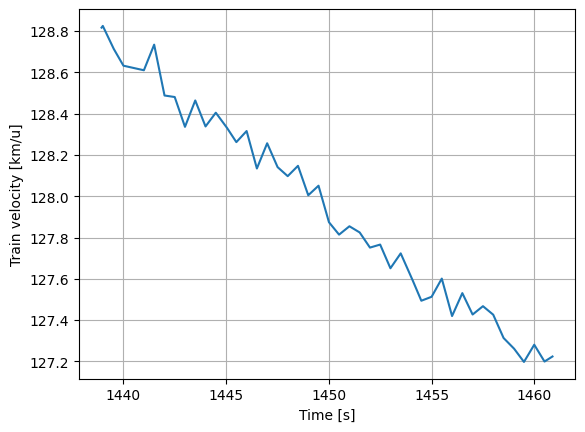

In [12]:
ricardo.plot_train_velocity(ricardo_data_within_bounds)
plt.grid()

## check acceleration signal

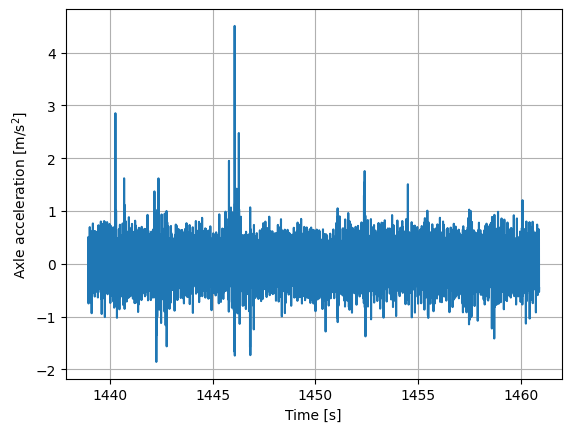

In [13]:
ricardo.plot_acceleration_signal(ricardo_data_within_bounds["time"], ricardo_data_within_bounds["acc_side_1"])
plt.grid()

# Filter inframon signal

In [14]:
# filter Ricardo measurements

# set filter settings
settings_filter = {"FS": 250,                   # acquisition frequency
                   "cut-off_high": 120,         # high cutoff frequency
                   "cut-off_low": 40,           # low cutoff frequency 
                   "n": 10,                     # order of the filter
                   "smoothing_distance": 10,    # distance of smoothed wavelength
                   }    

acceleration_data = ricardo_data_within_bounds["acc_side_1"]

# filter high frequencies
acc = signal_proc.filter_sig(acceleration_data,
                             settings_filter["FS"], settings_filter["cut-off_high"], settings_filter["n"],type="lowpass"
                             ).tolist()

# filter low frequencies
acc = signal_proc.filter_sig(acc,
                             settings_filter["FS"], settings_filter["cut-off_low"], settings_filter["n"],type="highpass"
                             ).tolist()

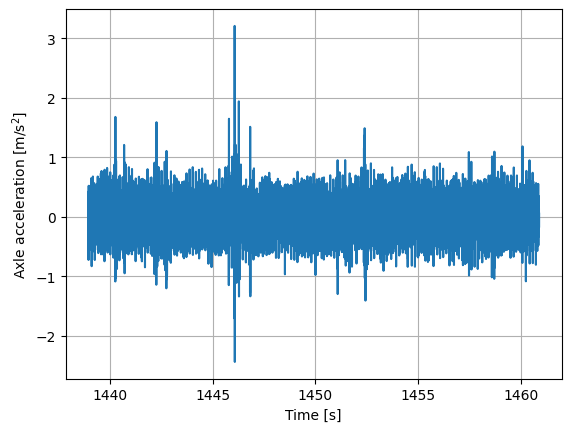

In [15]:
# plot filtered signal
ricardo.plot_acceleration_signal(ricardo_data_within_bounds["time"], acc)
plt.grid()

# Integrate acceleration signal to velocity signal



In [16]:
velocity = signal_proc.int_sig(acc, ricardo_data_within_bounds["time"], hp=True, mov=False, baseline=False, ini_cond=0)


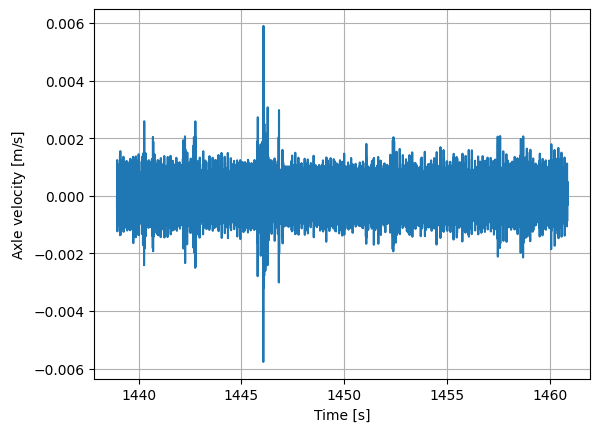

In [17]:
ricardo.plot_velocity_signal(ricardo_data_within_bounds["time"], acc)
plt.grid()

# Fast fourier transformation velocity signal

In [18]:
# fast fourier transformation of velocity signal
freq_velocity, ampl_velocity,_ = signal_proc.fft_sig(np.array(velocity), settings_filter["FS"])

# smooth signal
ampl_velocity = ricardo.smooth_signal_within_bounds_over_wave_length(ricardo_data_within_bounds, settings_filter["smoothing_distance"], ampl_velocity)

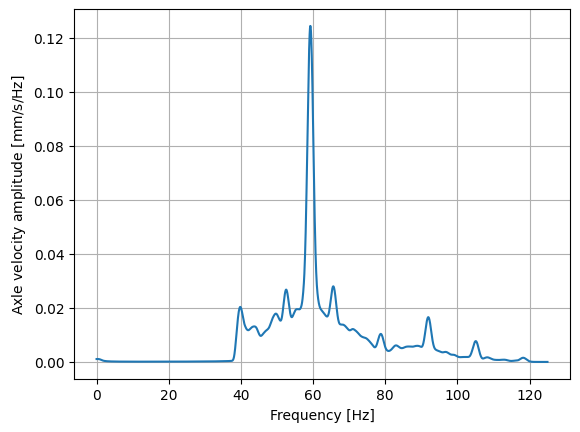

In [19]:
ricardo.plot_fft_velocity_signal(ricardo_data_within_bounds,acc, settings_filter["smoothing_distance"])
plt.grid()

In [20]:
# Get maximum velocity amplitude and corresponding frequency

m_to_mm = 1000

# maximum amplitude
max_vel_ampl = ampl_velocity[np.argmax(ampl_velocity)] * m_to_mm
# corresponding frequency
freq_at_max_vel = freq_velocity[np.argmax(ampl_velocity)]

In [21]:
max_vel_ampl, freq_at_max_vel 

(0.12437274245204348, 59.27647166028795)

# Check if frequency corresponds to the train speed
In this example, sleepers have a distance from eachother of 0.6 m. From the ricardo data, we can see that the average train speed over the segment is approximately 128 km/h. The frequency at the highest signal velocity should correspond to this train speed.

In [22]:
train_speed_mps = 128/3.6         # train speed in m/s
sleeper_dist = 0.6                # sleeper distance

load_frequency = train_speed_mps/sleeper_dist

In [23]:
load_frequency

59.25925925925927

# Update Rose model

In [24]:
# load results from rose demo

output_dir = "res"

with open(os.path.join(output_dir, "all_results.pickle"), 'rb') as f:
    coupled_model = pickle.load(f)["coupled_model"]

In [25]:
coupled_model.train.velocities

array([ 0.        ,  0.        ,  0.        , ..., 27.77777778,
       27.77777778, 27.77777778])

## reset velocities


In [26]:
# set velocity of train
velocities = np.ones(len(coupled_model.time)) * train_speed_mps

# prevent train from moving in initialisation phase
velocities[0:len(coupled_model.initialisation_time)] = 0
coupled_model.train.velocities = velocities

# Set optimisation parameters

In [27]:
optimisation = Optimisation()
optimisation.model=coupled_model
optimisation.observations =[freq_at_max_vel, max_vel_ampl]


optimisation_model_part = OptimisationModelPart()
optimisation_model_part.model_part = coupled_model.track.model_parts[4] # soil

# set the parameter in the corresponding model part which should be optimised
optimisation_model_part.optimisation_parameter_names = ["stiffness"]

# Set model result settings

## create a function to perform a fast fourier transformation on rose output

In [28]:
def results_function(signal, aq_freq):
    """
    Results function to be performed after a coupled calculation
    
    This functoin takes a signal, performs a fast fourier transformation and returns 
    the maximum amplitude in the frequency domain and the corresponding frequency 

    :param signal: signal to be processed
    :param aq_freq: aquisition frequency
    :return:
    """
    import rose.utils.signal_proc as signal_proc
    import matplotlib.pyplot as plt
    
    # filter signal
    signal2 = signal_proc.filter_sig(signal[:,0], aq_freq[0], 40, 6, "highpass")
    
    # fast fourier transformation
    freq, ampl,_ = signal_proc.fft_sig(signal2, aq_freq[0])

    # get maximum amplitude and corresponding frequency
    max_ampl_idx = np.argmax(ampl)
    max_freq = freq[max_ampl_idx]
    max_ampl = ampl[max_ampl_idx]
    return max_freq, max_ampl

## the results to be transformed are the velocities in the front wheel of the train

In [29]:
coupled_model.velocities_out

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.16666000e-40,  8.41923430e-39,  6.65067806e-35, ...,
        -2.63488351e-05,  4.65855034e-04,  4.62292050e-04],
       [ 8.39869951e-39, -2.53860164e-37,  1.45531471e-34, ...,
        -5.26359087e-05,  9.31541314e-04,  9.24424192e-04],
       ...,
       [ 2.73547352e-08,  9.44394326e-08,  8.72558910e-24, ...,
        -5.04534323e-03,  7.41147660e-03, -2.13997480e-03],
       [ 2.99739748e-08,  9.26045818e-08, -1.70786462e-23, ...,
        -5.07214684e-03,  7.37454726e-03, -2.31945121e-03],
       [ 3.25491629e-08,  9.06251567e-08, -4.29494902e-23, ...,
        -5.08901714e-03,  7.32193596e-03, -2.49181603e-03]])

## get the vertical displacement degree of freedom index of the front wheel of the train

In [30]:
result_index = coupled_model.train.wheels[-1].nodes[0].index_dof[1]

In [31]:
coupled_model.velocities_out[result_index,:]

array([-1.38700828e-09,  5.31322808e-09,  2.93289453e-21,  1.08476158e-09,
       -3.81682847e-10,  5.86459647e-21, -1.87100098e-09, -1.63050713e-09,
        8.79391379e-21,  3.12803593e-09,  6.00577252e-09,  1.17196560e-20,
       -5.07053539e-09, -1.52766608e-08,  1.46406341e-20,  7.72133514e-09,
        3.41173666e-08,  1.75556625e-20, -1.05689090e-08, -6.95435186e-08,
        2.04635577e-20,  1.17925370e-08,  1.29905964e-07,  2.33631418e-20,
       -7.04119558e-09, -2.20076327e-07,  2.62532392e-20, -1.18508629e-08,
        3.29362504e-07,  2.91326818e-20,  5.67205916e-08, -4.09659593e-07,
        3.20003065e-20, -1.38196194e-07,  3.48674226e-07,  3.48549526e-20,
        2.51373898e-07,  3.80563148e-08,  3.76954810e-20, -3.50055812e-07,
       -9.43525504e-07,  4.05207299e-20,  3.20773580e-07,  2.36638170e-06,
        4.33295923e-20,  4.91492582e-09, -3.76499509e-06,  4.61209218e-20,
       -7.35743086e-07,  3.78751678e-06,  4.88935951e-20,  1.67104911e-06,
       -6.44999321e-07,  

In [32]:
model_results = ModelResults()

# set name of result attribute as present in the coupled model
model_results.result_names = ["velocities_out"]
# set the index of the result to be used
model_results.result_indices = [result_index]
# set the timesteps to be used for the optimisation
model_results.time_step_indices = np.arange(int(len(coupled_model.initialisation_time)),int(len(coupled_model.time)))
# set result function
model_results.result_function = results_function

In [33]:
# calculate aquisition frequency
dt = np.diff(coupled_model.time)[-1]

aq_freq = 1/dt

# set model results arguments
model_results.args =[aq_freq]

## Initialise optimisation algorithm
The optimisation algorithm which is used is the levenberg marquart algorithm. Which is a gradient based algorithm which works efficiently when only a few parameters are to be optimised and the problem is not highly non-linear.

In [34]:
optimisation.model_results = [model_results]
optimisation.optimisation_model_parts = [optimisation_model_part]
optimisation.initialise()

## perform optimisation

In [35]:
initial_guess_stiffness = 5e7

In [36]:
optimisation.least_square(np.array([initial_guess_stiffness]), ftol=1e-8)

.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                                                           |  | |\|| //_\ | |_/
 | _ ) _  _ (_)     

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction
Initial static displacement of the train and the track


100%|██████████| 2.00/2.00 [00:00<00:00, 114steps/s]
100%|██████████| 1.00/1.00 [00:00<00:00, 995steps/s]


Calculating calculation phase


100%|██████████| 5.00k/5.00k [00:05<00:00, 971steps/s]  


Calculating calculation phase


100%|██████████| 8.00k/8.00k [00:06<00:00, 1.18ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction
Initial static displacement of the train and the track


100%|██████████| 2.00/2.00 [00:00<00:00, 588steps/s]
100%|██████████| 1.00/1.00 [00:00<00:00, 1.27ksteps/s]


Calculating calculation phase


100%|██████████| 5.00k/5.00k [00:04<00:00, 1.19ksteps/s]


Calculating calculation phase


100%|██████████| 8.00k/8.00k [00:06<00:00, 1.15ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction
Initial static displacement of the train and the track


100%|██████████| 2.00/2.00 [00:00<00:00, 634steps/s]
100%|██████████| 1.00/1.00 [00:00<00:00, 806steps/s]

Calculating calculation phase



100%|██████████| 5.00k/5.00k [00:05<00:00, 920steps/s]  


Calculating calculation phase


100%|██████████| 8.00k/8.00k [00:06<00:00, 1.18ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction
Initial static displacement of the train and the track


100%|██████████| 2.00/2.00 [00:00<00:00, 755steps/s]
100%|██████████| 1.00/1.00 [00:00<00:00, 786steps/s]


Calculating calculation phase


100%|██████████| 5.00k/5.00k [00:06<00:00, 794steps/s]  


Calculating calculation phase


100%|██████████| 8.00k/8.00k [00:07<00:00, 1.01ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction
Initial static displacement of the train and the track


100%|██████████| 2.00/2.00 [00:00<00:00, 495steps/s]
100%|██████████| 1.00/1.00 [00:00<00:00, 1.18ksteps/s]


Calculating calculation phase


  0%|          | 0.00/5.00k [00:00<?, ?steps/s]/home/bruno/software_dev/rose/rose/model/train_track_interaction.py:189: RuntimeWarning: invalid value encountered in power
  np.nan_to_num(np.power(1 / self.hertzian_contact_coef * (elastic_wheel_deformation - du_wheels)
 17%|█▋        | 827/5.00k [00:00<00:05, 824steps/s] 

ValueError: displacement in wheels is NAN, check if wheels are on track or reduce time steps

 17%|█▋        | 854/5.00k [00:18<00:05, 824steps/s]